# Students performance and difficulties prediction

In this notebook, we will:

- Predict whether or not a student will pass the final exam based on certain information given
- Compare the three learning algorithms
- Find out what most affects student achievement
- Find the best algorithm with high accuracy

We will be using three learning algorithms:

- Logistic regression
- Supported vector machine
- KNN

# Reading data

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, accuracy_score, f1_score
from astropy.table import Table


df = pd.read_csv('student-data.csv')

# Data

**Before process the data let's describe it briefly:**
- Source : **Paulo Cortez, University of Minho, GuimarÃ£es, Portugal**, http://www3.dsi.uminho.pt/pcortez

- This data approach student achievement in secondary education of two Portuguese schools.

- The shape of our data set is **(395 rows × 31 columns)**.

- **No missing** values in the data.

- The data attributes **include demographic**, social and school related features and it was collected by using school reports and questionnaires.

- **The last column tell us whether a student passed the final exam or not**.

- The dataset is taken from : https://archive.ics.uci.edu/ml/datasets/student+performance

**Now let's explain every column in the dataframe**
- `school` : student's school (binary: "GP" or "MS")
- `sex` : student's sex (binary: "F" - female or "M" - male)
- `age` : student's age (numeric: from 15 to 22)
- `address` : student's home address type (binary: "U" - urban or "R" - rural)
- `famsize` : family size (binary: "LE3" - less or equal to 3 or "GT3" - greater than 3)
- `Pstatus` : parent's cohabitation status (binary: "T" - living together or "A" - apart)
- `Medu` : mother's education (numeric: 0 - none,  1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
- `Fedu` : father's education (numeric: 0 - none,  1 - primary education (4th grade), 2 - 5th to 9th grade, 3 - secondary education or 4 - higher education)
- `Mjob` : mother's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
- `Fjob` : father's job (nominal: "teacher", "health" care related, civil "services" (e.g. administrative or police), "at_home" or "other")
- `reason` : reason to choose this school (nominal: close to "home", school "reputation", "course" preference or "other")
- `guardian` : student's guardian (nominal: "mother", "father" or "other")
- `traveltime` : home to school travel time (numeric: 1 - <15 min., 2 - 15 to 30 min., 3 - 30 min. to 1 hour, or 4 - >1 hour)
- `studytime` : weekly study time (numeric: 1 - <2 hours, 2 - 2 to 5 hours, 3 - 5 to 10 hours, or 4 - >10 hours)
- `failures` : number of past class failures (numeric: n if 1<=n<3, else 4)
- `schoolsup` : extra educational support (binary: yes or no)
- `famsup` : family educational support (binary: yes or no)
- `paid` : extra paid classes within the course subject (Math or Portuguese) (binary: yes or no)
- `activities` : extra-curricular activities (binary: yes or no)
- `nursery` : attended nursery school (binary: yes or no)
- `higher` : wants to take higher education (binary: yes or no)
- `internet` : Internet access at home (binary: yes or no)
- `romantic` : with a romantic relationship (binary: yes or no)
- `famrel` : quality of family relationships (numeric: from 1 - very bad to 5 - excellent)
- `freetime` : free time after school (numeric: from 1 - very low to 5 - very high)
- `goout` : going out with friends (numeric: from 1 - very low to 5 - very high)
- `Dalc` : workday alcohol consumption (numeric: from 1 - very low to 5 - very high)
- `Walc` : weekend alcohol consumption (numeric: from 1 - very low to 5 - very high)
- `health` : current health status (numeric: from 1 - very bad to 5 - very good)
- `absences` : number of school absences (numeric: from 0 to 93)

**The last column:**
- `passed` : did the student pass the final exam (binary: yes or no)

**Displaying the dataset**

In [26]:
df.iloc[0:5]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,no,no,4,3,4,1,1,3,6,no
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,yes,no,5,3,3,1,1,3,4,no
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,yes,no,4,3,2,2,3,3,10,yes
3,GP,F,15,U,GT3,T,4,2,health,services,...,yes,yes,3,2,2,1,1,5,2,yes
4,GP,F,16,U,GT3,T,3,3,other,other,...,no,no,4,3,2,1,2,5,4,yes


**Data processing**

In [27]:
# mapping strings to numeric values:
def numerical_data():
    df['school'] = df['school'].map({'GP': 0, 'MS': 1})
    df['sex'] = df['sex'].map({'M': 0, 'F': 1})
    df['address'] = df['address'].map({'U': 0, 'R': 1})
    df['famsize'] = df['famsize'].map({'LE3': 0, 'GT3': 1})
    df['Pstatus'] = df['Pstatus'].map({'T': 0, 'A': 1})
    df['Mjob'] = df['Mjob'].map({'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4})
    df['Fjob'] = df['Fjob'].map({'teacher': 0, 'health': 1, 'services': 2, 'at_home': 3, 'other': 4})
    df['reason'] = df['reason'].map({'home': 0, 'reputation': 1, 'course': 2, 'other': 3})
    df['guardian'] = df['guardian'].map({'mother': 0, 'father': 1, 'other': 2})
    df['schoolsup'] = df['schoolsup'].map({'no': 0, 'yes': 1})
    df['famsup'] = df['famsup'].map({'no': 0, 'yes': 1})
    df['paid'] = df['paid'].map({'no': 0, 'yes': 1})
    df['activities'] = df['activities'].map({'no': 0, 'yes': 1})
    df['nursery'] = df['nursery'].map({'no': 0, 'yes': 1})
    df['higher'] = df['higher'].map({'no': 0, 'yes': 1})
    df['internet'] = df['internet'].map({'no': 0, 'yes': 1})
    df['romantic'] = df['romantic'].map({'no': 0, 'yes' : 1})
    df['passed'] = df['passed'].map({'no': 0, 'yes': 1})
    # reorder dataframe columns :
    col = df['passed']
    del df['passed']
    df['passed'] = col

    
# feature scaling will allow the algorithm to converge faster, large data will have same scal
def feature_scaling(df):
    for i in df:
        col = df[i]
        # let's choose columns that have large values
        if(np.max(col)>6):
            Max = max(col)
            Min = min(col)
            mean = np.mean(col)
            col  = (col-mean)/(Max)
            df[i] = col
        elif(np.max(col)<6):
            col = (col-np.min(col))
            col /= np.max(col)
            df[i] = col
        
# This function will transform dataframe to a numpy array and split it
def split(df,test_size):
    data = df.to_numpy()
    n = data.shape[1]
    x = data[:,0:n-1]
    y = data[:,n-1]
    X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=test_size, random_state=0)
    return X_train,X_test,y_train,y_test

**digitization of values**

In [28]:
# All values in numerical after calling numerical_data() function
numerical_data()
df.iloc[0:5]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,0,1,18,0,1,1,4,4,3,0,...,0,0,4,3,4,1,1,3,6,0
1,0,1,17,0,1,0,1,1,3,4,...,1,0,5,3,3,1,1,3,4,0
2,0,1,15,0,0,0,1,1,3,4,...,1,0,4,3,2,2,3,3,10,1
3,0,1,15,0,1,0,4,2,1,2,...,1,1,3,2,2,1,1,5,2,1
4,0,1,16,0,1,0,3,3,4,4,...,0,0,4,3,2,1,2,5,4,1


**Data visualization**

**Features scalling**

In [29]:
feature_scaling(df)
X_train,X_test,y_train,y_test = split(df,0.2)

# Now we are ready for models training
df.iloc[0:3]

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,internet,romantic,famrel,freetime,goout,Dalc,Walc,health,absences,passed
0,0.0,1.0,0.059264,0.0,1.0,1.0,1.00,1.00,0.75,0.0,...,0.0,0.0,0.75,0.5,0.75,0.00,0.0,0.5,0.003882,0.0
1,0.0,1.0,0.013809,0.0,1.0,0.0,0.25,0.25,0.75,1.0,...,1.0,0.0,1.00,0.5,0.50,0.00,0.0,0.5,-0.022785,0.0
2,0.0,1.0,-0.077100,0.0,0.0,0.0,0.25,0.25,0.75,1.0,...,1.0,0.0,0.75,0.5,0.25,0.25,0.5,0.5,0.057215,1.0


# Logistic regression

In [30]:
# call split(df, test_size)

# k-nearest neighbors

In [31]:
# call split(df, test_size)

# Support vector machine 

In [32]:
# Mohammed AL JADD
# Functions will help us


# ------------------------------------------------------------------------------------------------------------------------------
# Show results of every model-

def showResults(accuracy, trainingTime, y_pred,model):
    
    print('------------------------------------------------Results :',model,'-----------------------------------------------------')
    confusionMatrix = confusion_matrix(y_test, y_pred)
    print('\n The ROC curve is :\n')
    fpr,tpr,thresholds=roc_curve(y_test,y_pred)
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label=model)
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    plt.show()
    print('----------------------------------------------')
    print('The model  accuracy:', accuracy,'%')
    print('----------------------------------------------')
    print('The confusion matrix is :\n',confusionMatrix)
    print('----------------------------------------------')
    print('The training time is: ',trainingTime)
    print('----------------------------------------------')
    print('The f1 score is :',f1_score(y_test, y_pred, average='macro'))  
    print('--------------------------------------------------------------------------------------------------------------------')
    


    
# ------------------------------------------------------------------------------------------------------------------------------
# C, degree and gamma are the parameters that are used in SVM classffier 'svc(C=..,..),svc(C,degree=..)',svc(C,gamma=..)
# The following functions will return those values that minimize the error on (X_val,y_val) set
# So this (X_val,y_val) set will be used to get the optimal SVM parameters before evaluating the model on the test set


# Optimal C 
def optimal_C_value():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    minError = float('Inf')
    optimal_C = float('Inf')

    for c in Ci:
        clf = SVC(C=c,kernel='linear')
        clf.fit(X_train, y_train)
        predictions = clf.predict(X_val)
        error = np.mean(np.double(predictions != y_val))
        if error < minError:
            minError = error
            optimal_C = c
    return optimal_C


# Optimal C and the degree of the polynomial
def optimal_C_d_values():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    Di = np.array(( 2, 5, 10, 15, 20, 25, 30))
    minError = float('Inf')
    optimal_C = float('Inf')
    optimal_d = float('Inf')

    for d in Di:
        for c in Ci:
            clf = SVC(C=c,kernel='poly', degree=d)
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_val)
            error = np.mean(np.double(predictions != y_val))
            if error < minError:
                minError = error
                optimal_C = c
                optimal_d = d
    return optimal_C,optimal_d


# Optimal C and gamma
def optimal_C_gamma_values():
    Ci = np.array(( 0.0001,0.001,0.01,0.05,0.1,4,10,40,100))
    Gi = np.array(( 0.000001,0.00001,0.01,1,2,3,5,20,70,100,500,1000))
    minError = float('Inf')
    optimal_C = float('Inf')
    optimal_g = float('Inf')

    for g in Gi:
        for c in Ci:
            clf = SVC(C=c,kernel='rbf', gamma=g)
            clf.fit(X_train, y_train)
            predictions = clf.predict(X_val)
            error = np.mean(np.double(predictions != y_val))
            if error < minError:
                minError = error
                optimal_C = c
                optimal_g = g
    return optimal_C,optimal_g


# ------------------------------------------------------------------------------------------------------------------------------
# Compare the three kernels


def compare_kernels():
    print('------------------------------------------------ Comparison -----------------------------------------------------')
    print('\n')
    f11 = "{:.2f}".format(f1_score(y_test, y_linear, average='macro'))
    f22 = "{:.2f}".format(f1_score(y_test, y_poly, average='macro'))
    f33 = "{:.2f}".format(f1_score(y_test, y_gauss, average='macro'))
    a1,a2 = confusion_matrix(y_test, y_linear)[0],confusion_matrix(y_test, y_linear)[1]
    b1,b2 = confusion_matrix(y_test, y_poly)[0],confusion_matrix(y_test, y_poly)[1]
    c1,c2 = confusion_matrix(y_test, y_gauss)[0],confusion_matrix(y_test, y_gauss)[1]
    data_rows = [('training time',time1, time2, time3),
                 ('','','',''),
                  ('accuracy %',linear_accuracy, poly_accuracy, gauss_accuracy),
                 ('','','',''),
                 ('confusion matrix',a1, b1, c1),
                ('',a2,b2,c2),
                 ('','','',''),
                ('f1 score',f11,f22,f33)]
    t = Table(rows=data_rows, names=('metrice','Linear kernel', 'polynomial kernel', 'gaussian kernel'))
    print(t)
    print('\n\n')
    print('The Roc curves :\n')
    y_pred1 = y_linear
    y_pred2 = y_poly
    y_pred3 = y_gauss
    
    fpr,tpr,thresholds=roc_curve(y_test,y_pred1)
    plt.plot([0, 1],[0, 1],'--')
    plt.plot(fpr,tpr,label='Linear kernel')
    plt.xlabel('false positive')
    plt.ylabel('false negative')
    fpr,tpr,thresholds=roc_curve(y_test,y_pred2)
    plt.plot(fpr,tpr,label='Polynomial kernel')
    fpr,tpr,thresholds=roc_curve(y_test,y_pred3)
    plt.plot(fpr,tpr,label='Gaussian kernel')
    plt.legend()
    plt.show()


# ------------------------------------------------------------------------------------------------------------------------------
# Print results of the choosen kernel

def best_kernel(kernel):
    time = 0
    f1 = 0
    accuracy = 0
    if kernel == 'linear kernel':
        time = time1
        f1 = "{:.2f}".format(f1_score(y_test, y_linear, average='macro'))
        accuracy = linear_accuracy
    elif kernel == 'polynomial kernel':
        time = time2
        f1 = "{:.2f}".format(f1_score(y_test, y_poly, average='macro'))
        accuracy = poly_accuracy
    else :
        time = time3
        f1 = "{:.2f}".format(f1_score(y_test, y_gauss, average='macro'))
        accuracy = gauss_accuracy
    print('The choosen kernel :',kernel)
    print('the training :',time)
    print('the accuracy :',round(accuracy),'%')
    print('the f1 score :',f1)
    
    
    
    
    
# ------------------------------------------------------------------------------------------------------------------------------
# Splitting the data for SVM
# Here We will split data into test set, cross validation (X_val, y_val) set and training set
# The cross validation (X_val, y_val) is used for choosing the optimal value for svm parameters C, degree and gamma
data = df.to_numpy()
n = data.shape[1]    
x = data[:,0:n-1]
y = data[:,n-1]
X_train,X_rest,y_train,y_rest = train_test_split(x,y,test_size=0.4, random_state=0)
X_val,X_test,y_val,y_test = train_test_split(X_rest,y_rest,test_size=0.4, random_state=0) 

# We will use the three different svm classifier kernels
# Linear kernel, polynomial kernel and gaussian kernel and we will choose the most accurate

**Linear Kernel :**

------------------------------------------------Results : SVM linear kernel -----------------------------------------------------

 The ROC curve is :



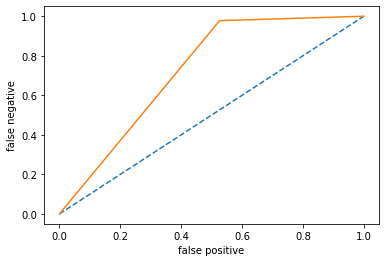

----------------------------------------------
The model  accuracy: 82.8125 %
----------------------------------------------
The confusion matrix is :
 [[ 9 10]
 [ 1 44]]
----------------------------------------------
The training time is:  15ms
----------------------------------------------
The f1 score is : 0.7547892720306513
--------------------------------------------------------------------------------------------------------------------


In [33]:
###################################################### Linear kernel ###########################################################

# Let's get the optimal C value for the linear kernal
optimal_C = optimal_C_value()


# Now let's use the optimal C value
linear_clf = SVC(C=optimal_C,kernel='linear')

# Let's train the model with the optimal C value and calculate the training time
tic = time.time()
linear_clf.fit(X_train, y_train)
toc = time.time()
time1 = str(round(1000*(toc-tic))) + "ms"
y_linear = linear_clf.predict(X_test)
linear_accuracy = accuracy_score(y_test, y_linear)*100

# Let's show the resuls
showResults(linear_accuracy, time1, y_linear,'SVM linear kernel')

**Polynomial Kernel :**

------------------------------------------------Results : SVM polynomial kernel -----------------------------------------------------

 The ROC curve is :



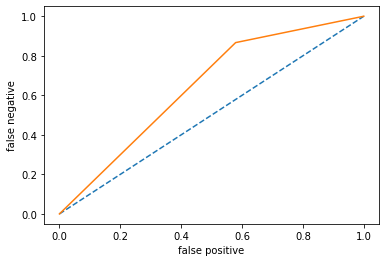

----------------------------------------------
The model  accuracy: 73.4375 %
----------------------------------------------
The confusion matrix is :
 [[ 8 11]
 [ 6 39]]
----------------------------------------------
The training time is:  5ms
----------------------------------------------
The f1 score is : 0.6529505582137161
--------------------------------------------------------------------------------------------------------------------


In [34]:
###################################################### Polynomial kernel ######################################################

# Let's get the optimal C and the degree value for the polynomial kernal
optimal_C, optimal_d = optimal_C_d_values()

# Now let's use the optimal c value and the optimal degree value
poly_clf = SVC(C=optimal_C,kernel='poly', degree=optimal_d)

# Let's train the model with the optimal C value and calculate the training time
tic = time.time()
poly_clf.fit(X_train, y_train)
toc = time.time()
time2 = str(round(1000*(toc-tic))) + "ms"
y_poly = poly_clf.predict(X_test)
poly_accuracy = (accuracy_score(y_test, y_poly)*100)

# Let's show the resuls
showResults(poly_accuracy, time2, y_poly,'SVM polynomial kernel')

**Gaussian Kernel :**

------------------------------------------------Results : SVM gaussian kernel -----------------------------------------------------

 The ROC curve is :



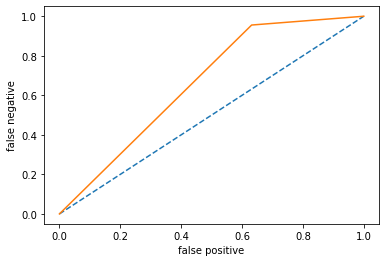

----------------------------------------------
The model  accuracy: 78.125 %
----------------------------------------------
The confusion matrix is :
 [[ 7 12]
 [ 2 43]]
----------------------------------------------
The training time is:  9ms
----------------------------------------------
The f1 score is : 0.6799999999999999
--------------------------------------------------------------------------------------------------------------------


In [35]:
###################################################### Gaussian kernel ######################################################

# Let's get the optimal C value for the gaussian kernal
optimal_C, optimal_gamma = optimal_C_gamma_values() 

# Now let's use the optimal c value
gauss_clf = SVC(C=optimal_C,kernel='rbf',gamma=optimal_gamma)

# Let's train the model with the optimal C value and calculate the training time
tic = time.time()
gauss_clf.fit(X_train, y_train)
toc = time.time()
time3 = str(round(1000*(toc-tic))) + "ms"
y_gauss = gauss_clf.predict(X_test)
gauss_accuracy = (accuracy_score(y_test, y_gauss)*100)

# Let's show the resuls
showResults(gauss_accuracy, time3, y_gauss,'SVM gaussian kernel')

**Comparison of the three svm kernels**

------------------------------------------------ Comparison -----------------------------------------------------


    metrice      Linear kernel polynomial kernel gaussian kernel
---------------- ------------- ----------------- ---------------
   training time          15ms               5ms             9ms
                                                                
      accuracy %       82.8125           73.4375          78.125
                                                                
confusion matrix       [ 9 10]           [ 8 11]         [ 7 12]
                       [ 1 44]           [ 6 39]         [ 2 43]
                                                                
        f1 score          0.75              0.65            0.68



The Roc curves :



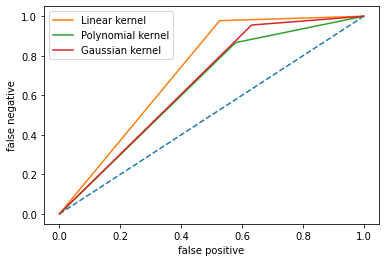

In [37]:
compare_kernels()

# Comparison of the three algorithms